# 決定木
- 疑似データに対して人力で境界線を引いて、決定木のイメージを確認しよう
- scikit-learnを用いて決定木を作成し、graphvizを使って可視化してみよう

## 1. ライブラリの読み込み

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# アヤメの品種分類データセット
from sklearn.datasets import load_iris
# ホールドアウト法を実行するための関数
from sklearn.model_selection import train_test_split 
# 分類問題の評価指標
from sklearn.metrics import accuracy_score, classification_report

# 決定木の実装、DOTファイルへの出力
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# ファイルの入出力を文字列として保持
from io import StringIO
# グラフ構造を可視化
import graphviz
from pydotplus import graph_from_dot_data
# 画像データを表示
from IPython.display import Image

## 2. 疑似データの作成

,x1,x2,label
0,0.10,0.1,1
1,0.10,0.5,0
2,0.20,0.7,0
3,0.25,0.2,1
4,0.20,0.6,0


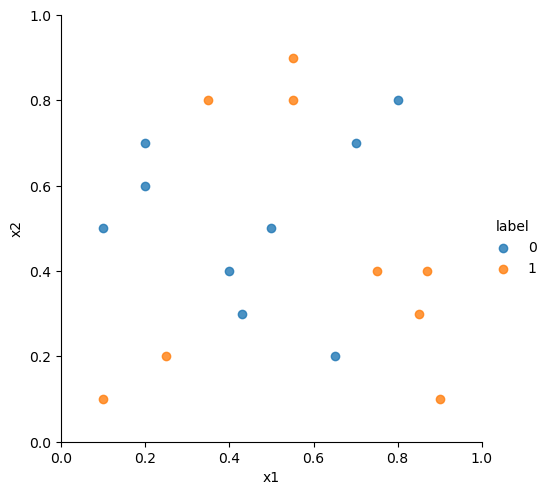

In [2]:
df = pd.DataFrame({
    "x1":[0.1,0.1,0.2,0.25,0.2,0.35,0.4,0.43,0.65,0.55,0.55,0.5,0.75,0.7,0.85,0.87,0.8,0.9],
    "x2":[0.1,0.5,0.7,0.2,0.6,0.8,0.4,0.3,0.2,0.9,0.8,0.5,0.4,0.7,0.3,0.4,0.8,0.1],
    "label":[1,0,0,1,0,1,0,0,0,1,1,0,1,0,1,1,0,1]
})
display(df.head())

# Seabornを用いて散布図を表示
# fit_reg=Falseで回帰直線を非表示
sns.lmplot(x="x1", y="x2", hue="label", data=df,fit_reg=False)

# 表示範囲の調整
plt.ylim([0,1]),plt.xlim([0,1])
plt.show()

## 3. 人力で境界線を設定
* ラベル0とラベル1を識別するための境界線を引いてみよう
* 境界線を引くときのルール
    * 境界線は、複数引いてもよいが、なるべく少ない方がよい
    * 境界線は、x1軸またはx2軸に平行にすること
    * 境界線どうしは交差してはならない
    * 全データのクラスを完璧に識別できるものにすること
    * 緑の線に行き着くか、無限遠まで伸ばす

### 3-1. 関数の定義

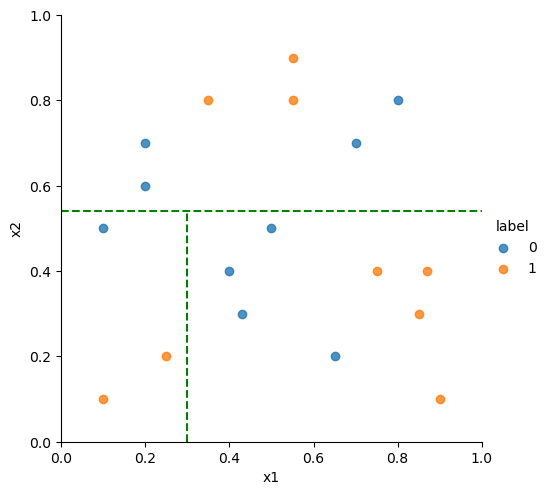

In [3]:
# 散布図と境界線を表示する関数
def decision_line(start_points, end_points):
    # 散布図の表示
    sns.lmplot(x="x1", y="x2", hue="label", data=df,fit_reg=False)
    plt.ylim([0,1]),plt.xlim([0,1])

    # 境界線の表示
    for sp, ep in zip(start_points, end_points):
        X = [sp[0], ep[0]]
        Y = [sp[1], ep[1]]
        plt.plot(X, Y, ls = "--",color="g")


# 始点の座標
start_points = [[0.00, 0.54], [0.30, 0.00]] 
# 終点の座標
end_points = [[1.00, 0.54], [0.30, 0.54]]

# 関数の実行
decision_line(start_points, end_points)
plt.show()

### 3-2. [演習] 境界線の変更

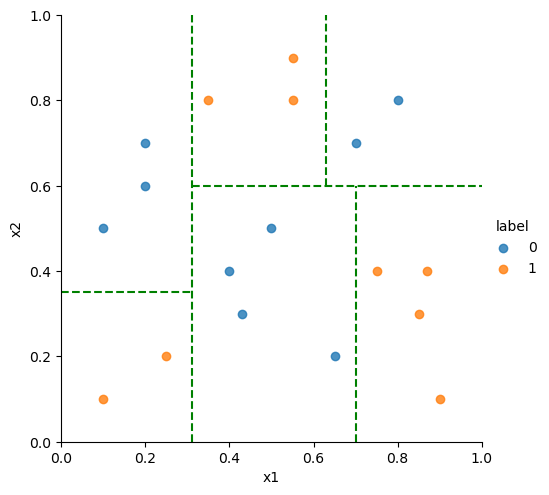

In [4]:
# 始点の座標（ここを編集）
start_points = [[0.31, 0.00], [0.31, 0.60], [0.70, 0.00], [0.63, 0.60], [0.00, 0.35]] 
# 終点の座標（ここを編集）
end_points =   [[0.31, 1.00], [1.00, 0.60], [0.70, 0.60], [0.63, 1.00], [0.31, 0.35]]

# 関数の実行
decision_line(start_points, end_points)
plt.show()

### 3-3. 汎化性能の確認
* クラス0のデータX_test_0と、クラス1のデータX_test_1が新たに観測された
* 先程作成した識別境界では、0と1を正しく識別できるだろうか？

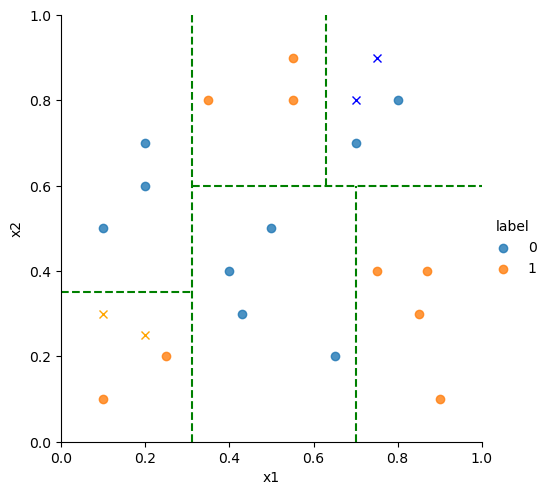

In [5]:
# クラス0のテストデータ
X_test_0 = [[0.70, 0.80], [0.75, 0.90]]
# クラス1のテストデータ
X_test_1 = [[0.10, 0.30], [0.20, 0.25]]

# 学習用データと境界線を表示
decision_line(start_points, end_points)

# クラス0のデータを、青色の×として表示
for point in X_test_0:
    plt.plot(point[0], point[1], marker="x",color="blue")
# クラス1のデータを、オレンジ色の×として表示
for point in X_test_1:
    plt.plot(point[0], point[1], marker="x",color="orange")

plt.show()

## 4. 疑似データを用いた決定木の学習

### 決定木
* 単純な識別器の組みわせによって、複雑な識別境界を構成する手法
    * 回帰問題にも用いることができる
* 条件分岐を増やしていくことで、木を成長させていく
    * 基本的には、左と右に分かれる2分木
* どの条件分岐が良いかは、不純度によって判断する
    * 現在のノードの不純度と、分岐後の左右ノードの不純度合計を比較
    * 最も不純度が減る（情報利得が大きい）分岐を採用する

        
### 一般的によく使われる不純度(Impurity)

#### エントロピー(Entropy)
- 確率変数のばらつきを表す指標  
- $\displaystyle I(t) = - \sum^C_{i=1} p(C_i|t)\log_2p(C_i|t)$  
  


#### ジニ係数(Gini Impurity)
- 誤分類する確率を平均化した指標  
- $\displaystyle I(t) = \sum^C_{i=1} p(C_i|t)(1-p(C_i|t)) = 1 - \sum^C_{i=1} p(C_i|t)^2$
  - $I(t)$: ノード$t$における不純度  
  - $p(C_i|t)$: ノード$t$において、クラス$C_i$になる確率

### 4-1. モデルの構築・学習
- [DecisionTreeClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
  - 決定木による分類モデルを構築
- パラメータの意味
    - criterion
        - 不純度の評価方法
        - "gini"（ジニ係数）または "entropy"（エントロピー）を設定
    - max_depth
        - 決定木の最大深度
        - 葉ノードに辿り着くまでに分岐を何回行うか
    - min_samples_split
        - ノードを分割するために必要な最小サンプル数
        - これを満たさないノードは分割できない
    - min_samples_leaf
        - 葉ノードが持つべき最小サンプル数
        - これを満たさないノードは作成できない

In [6]:
# 説明変数
X_train = df[["x1","x2"]].values
# 目的変数
y_train = df["label"].values

# 決定木モデルの構築
clf = DecisionTreeClassifier(
    criterion="gini", max_depth=None, 
    min_samples_split=3, min_samples_leaf=3, 
    random_state=1234)

# モデルの学習
clf.fit(X_train, y_train)

# 訓練性能の確認
print("train_accuracy:", clf.score(X_train, y_train))

train_accuracy: 0.8333333333333334


### 4-2. モデルの評価
- 決定木は過学習を起こしやすい

In [7]:
# 説明変数
X_test = X_test_0 + X_test_1 # リストの結合

# 目的変数
y_test = [0, 0, 1, 1]

# テスト用データに対する予測
y_pred = clf.predict(X_test)
print("predicted_class:", y_pred)
print("test_accuracy:", accuracy_score(y_test, y_pred))

predicted_class: [1 1 1 1]
test_accuracy: 0.5


### [演習]
* 不純度の評価方法を変更してみましょう
* max_depthの値を変更してみましょう
* min_samples_splitの値を変更してみましょう
* min_samples_leafの値を変更してみましょう

### 4-3. 変数の重要度を確認

[0.44137931 0.55862069]


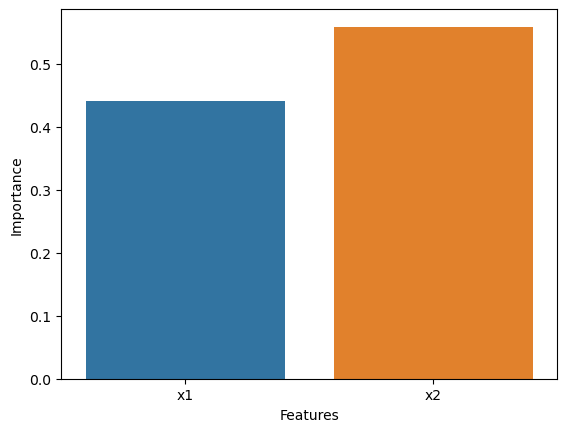

In [8]:
# 説明変数の重要度を出力する
# 重要度＝ある説明変数による不純度の減少量の合計
print(clf.feature_importances_)

# データフレームの作成
df = pd.DataFrame(clf.feature_importances_, index=["x1","x2"])
df = df.reset_index()

# 棒グラフの表示
sns.barplot(x='index', y=0, data=df)
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### 4-4. モデルの可視化
- [export_graphviz()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html)を用いてモデルをDOTファイルとして出力
    - out_file: DOTファイルの保存先
    - filled: 条件分岐の四角形を塗りつぶす
    - rounded: 条件分岐の四角形の角を丸くする
    - special_characters: 特殊文字を表示する
- [graph_from_dot_data()](https://pydotplus.readthedocs.io/reference.html#pydotplus.graphviz.graph_from_dot_data)を用いて、DOTファイルを可視化
    - 分岐条件を詳しく確認できる


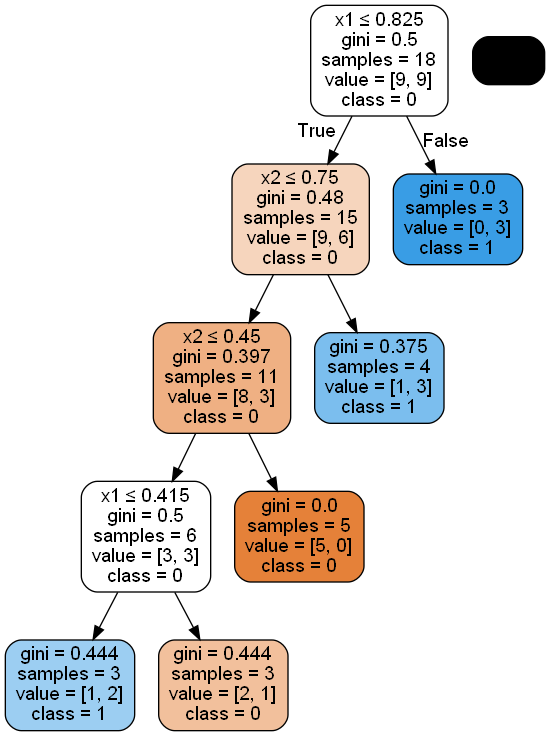

In [9]:
# DOTファイルの格納先（文字列として保持）
dot_data = StringIO()

# モデルをDOTファイルとして出力
export_graphviz(
    clf, out_file=dot_data,  
    feature_names=["x1", "x2"],  
    class_names=["0","1"],  
    filled=True, rounded=True,  
    special_characters=True
) 

# DOTファイルを読み込む
graph = graph_from_dot_data(dot_data.getvalue()) 

# PNG形式の画像として表示
Image(graph.create_png())

## 5. Irisデータセットを用いた決定木の学習
- [The Iris Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)
  - アヤメの品種分類のデータセット
  - 目的変数（クラス）
      - Setosa
      - Versicolor
      - Virginica
  - 説明変数
      - Sepal Length（萼片の長さ）
      - Sepal Width（萼片の幅）
      - Petal Length（花弁の長さ）
      - Petal Width（花弁の幅）

### 5-1. データの読み込み


In [10]:
# データセットの読み込み
iris = load_iris()

# 説明変数をデータフレームに変換
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
# 目的変数をデータフレームに追加
df_iris["label"] = iris.target

# クラス番号を文字列に置き換え
df_iris["label"] = df_iris["label"].map(
    {0:iris.target_names[0], 
     1:iris.target_names[1], 
     2:iris.target_names[2]}
)

df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### 5-2. データの可視化

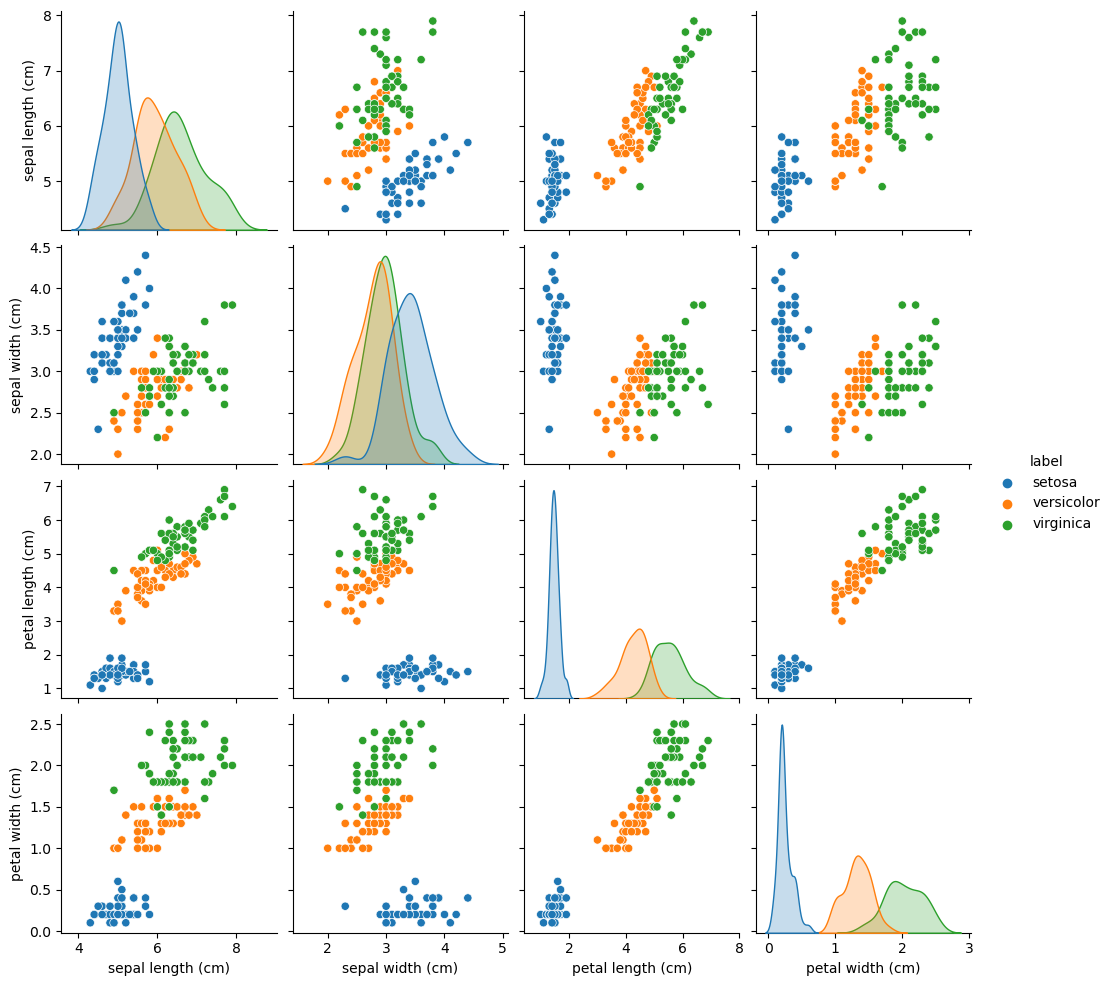

In [11]:
# 散布図行列の表示（クラスごとに色分け）
sns.pairplot(df_iris, hue="label")
plt.show()

### 5-3. モデルの構築・学習

In [12]:
# 学習用・テスト用の分割
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.4, random_state=1234
) 

# モデルの構築
clf = DecisionTreeClassifier(
    criterion="gini", max_depth=None, 
    min_samples_leaf=3, random_state=1234)

# モデルの学習
clf.fit(X_train, y_train)

# 訓練性能の確認
print("train_accuracy:", clf.score(X_train, y_train))

train_accuracy: 0.9777777777777777


### 5-4. モデルの評価

In [13]:
# 汎化性能の確認
print("test_accuracy:", clf.score(X_test, y_test))

# 予測結果の取得
y_pred = clf.predict(X_test)

# 混同行列の確認
scores = classification_report(y_test, y_pred)
print(scores)

test_accuracy: 0.9833333333333333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.96      0.98        23
           2       0.95      1.00      0.97        18

    accuracy                           0.98        60
   macro avg       0.98      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



### 5-5. 変数の重要度を確認

[0.         0.         0.61454019 0.38545981]


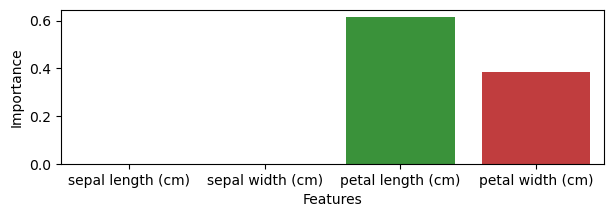

In [14]:
# 説明変数の重要度を出力する
# 重要度＝ある説明変数による不純度の減少量の合計
print(clf.feature_importances_)

# データフレームの作成
feature_imp = pd.DataFrame(
    clf.feature_importances_, 
    index=iris.feature_names, columns=['Importance']
)

# 棒グラフの表示
plt.figure(figsize=(7,2))
sns.barplot(x=feature_imp.index, y=feature_imp['Importance'])
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

- ヒストグラムをクラスごとに分ける際の分けやすさと対応している

### 5-6. モデルの可視化

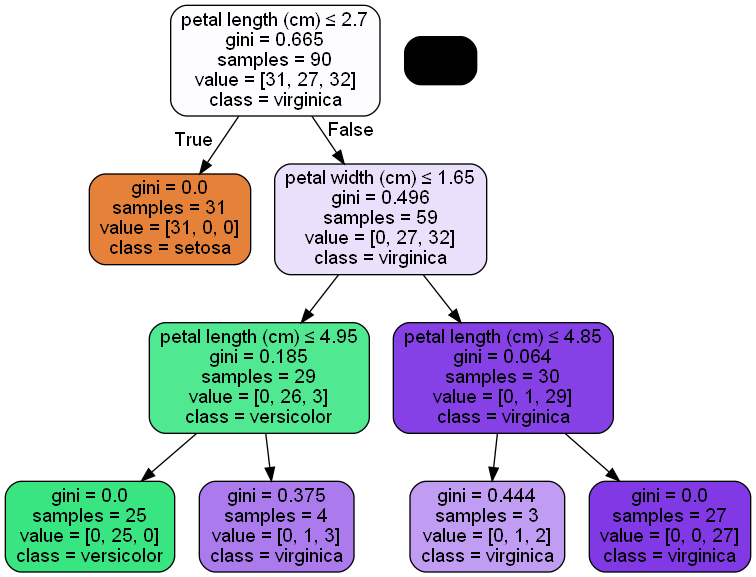

In [15]:
# DOTファイルの格納先（文字列として保持）
dot_data = StringIO()

# モデルをDOTファイルとして出力
export_graphviz(
    clf, out_file=dot_data,  
    feature_names=iris.feature_names,  
    class_names=iris.target_names,  
    filled=True, rounded=True,  
    special_characters=True
) 

# DOTファイルを読み込む
graph = graph_from_dot_data(dot_data.getvalue()) 

# PNG形式の画像として表示
Image(graph.create_png())